In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [72]:
df_imp = pd.read_excel('IMPORTACION-VOLUMEN-2023-05.xlsx', sheet_name='IMPORTACION',skiprows = 6,
                            nrows=270, header=0,usecols= 'A, G, I, K, L, U', engine='openpyxl').dropna()

df_imp.head()

,Fecha,Diesel bajo azufre,Gas licuado de petróleo,Gasolina regular,Gasolina superior,Diesel alto azufre
0,2001-01-01,0.0,194065.738095,177776.50,373963.96,566101.99
1,2001-02-01,0.0,170703.380952,123115.99,243091.07,489525.80
2,2001-03-01,0.0,161837.371429,161726.42,312084.38,575559.68
3,2001-04-01,0.0,163048.642857,127338.74,285054.89,437745.42
4,2001-05-01,0.0,171518.861905,168730.19,300913.67,552609.13


In [73]:
df_imp.tail()

,Fecha,Diesel bajo azufre,Gas licuado de petróleo,Gasolina regular,Gasolina superior,Diesel alto azufre
264,2023-01-01,1442099.08,497780.69,909391.13,578792.14,0.0
265,2023-02-01,1267967.39,652984.71,725101.20,685183.06,0.0
266,2023-03-01,1317519.91,711978.35,803262.67,633849.05,0.0
267,2023-04-01,1417182.73,647666.30,922032.39,572201.36,0.0
268,2023-05-01,1428099.62,713348.99,947633.29,668478.73,0.0


In [74]:
(df_imp.iloc[:,1] != 0).idxmax(), (df_imp.iloc[:,5] == 0).idxmax() # las volumnas se pueden sumar en una sola

(204, 204)

In [75]:
df_imp['Diesel'] = df_imp['Diesel bajo azufre'] + df_imp['Diesel alto azufre']
df_imp.drop(['Diesel bajo azufre', 'Diesel alto azufre'], axis=1, inplace=True)

In [76]:
df_imp.info(), df_imp.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269 entries, 0 to 268
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Fecha                    269 non-null    datetime64[ns]
 1   Gas licuado de petróleo  269 non-null    float64       
 2   Gasolina regular         269 non-null    float64       
 3   Gasolina superior        269 non-null    float64       
 4   Diesel                   269 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 12.6 KB


(None, (269, 5))

In [77]:
df_imp.describe().applymap(lambda x: f"{int(x):,}")

,Gas licuado de petróleo,Gasolina regular,Gasolina superior,Diesel
count,269,269,269,269
mean,"399,026","381,883","478,288","863,979"
std,"190,173","219,364","153,277","276,545"
min,"100,561","81,015","170,292","229,764"
25%,"218,257","201,907","363,352","678,749"
50%,"396,363","305,285","456,588","824,047"
75%,"540,671","528,347","582,374","1,050,560"
max,"960,840","987,872","1,227,173","1,595,698"


In [78]:
df_p_nac_1 = pd.read_excel('Precios-Promedio-Nacionales-Diarios-2023.xlsx', sheet_name='2021',skiprows = 6,
                            nrows=366, header=0,usecols= 'A,C:E, G', engine='openpyxl')
df_p_nac_1.drop(0, inplace=True)
df_p_nac_2 = pd.read_excel('Precios-Promedio-Nacionales-Diarios-2023.xlsx', sheet_name='2022',skiprows = 6,
                            nrows=366, header=0,usecols= 'A,C:E, G', engine='openpyxl')
df_p_nac_2.drop(0, inplace=True)
df_p_nac_3 = pd.read_excel('Precios-Promedio-Nacionales-Diarios-2023.xlsx', sheet_name='2023',skiprows = 7,
                            nrows=213, header=0,usecols= 'A,C:E, G', engine='openpyxl')
df_p_nac_3.drop(0, inplace=True)

In [79]:
df_p_nac_1.head()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
1,2021-01-01,21.91,21.11,17.61,99
2,2021-01-02,21.91,21.11,17.61,99
3,2021-01-03,21.91,21.11,17.61,99
4,2021-01-04,21.91,21.11,17.61,99
5,2021-01-05,21.91,21.11,17.61,99


In [80]:
df_p_nac_1.tail()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
361,2021-12-27,28.69,27.91,24.51,122
362,2021-12-28,28.69,27.91,24.51,122
363,2021-12-29,28.69,27.91,24.51,122
364,2021-12-30,28.69,27.91,24.51,122
365,2021-12-31,28.69,27.91,24.51,122


In [81]:
df_p_nac_2.head()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
1,2022-01-01,28.69,27.91,24.51,122
2,2022-01-02,28.69,27.91,24.51,122
3,2022-01-03,28.79,27.99,24.6,122
4,2022-01-04,28.79,27.99,24.6,122
5,2022-01-05,28.79,27.99,24.6,122


In [82]:
df_p_nac_2.tail()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
361,2022-12-27,32.55,30.99,33.75,122
362,2022-12-28,32.55,30.99,33.75,122
363,2022-12-29,32.55,30.99,33.75,122
364,2022-12-30,32.55,30.99,33.75,122
365,2022-12-31,32.55,30.99,33.75,122


In [83]:
df_p_nac_3.head()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
1,2023-01-01,32.55,30.99,33.75,122
2,2023-01-02,32.55,30.99,33.75,122
3,2023-01-03,32.56,31.42,35.31,122
4,2023-01-04,32.56,31.42,35.31,122
5,2023-01-05,32.56,31.42,35.31,122


In [84]:
df_p_nac_3.tail()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
208,2023-07-27,34.78,33.28,28.47,135
209,2023-07-28,34.78,33.28,28.47,135
210,2023-07-29,34.78,33.28,28.47,135
211,2023-07-30,34.78,33.28,28.47,135
212,2023-07-31,36.29,34.77,29.68,135


In [85]:
df_precios = pd.concat([df_p_nac_1, df_p_nac_2, df_p_nac_3], ignore_index=True)
df_precios.head()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
0,2021-01-01,21.91,21.11,17.61,99
1,2021-01-02,21.91,21.11,17.61,99
2,2021-01-03,21.91,21.11,17.61,99
3,2021-01-04,21.91,21.11,17.61,99
4,2021-01-05,21.91,21.11,17.61,99


In [86]:
df_precios.tail()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
937,2023-07-27,34.78,33.28,28.47,135
938,2023-07-28,34.78,33.28,28.47,135
939,2023-07-29,34.78,33.28,28.47,135
940,2023-07-30,34.78,33.28,28.47,135
941,2023-07-31,36.29,34.77,29.68,135


In [87]:
df_precios.info(), df_precios.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   FECHA                942 non-null    datetime64[ns]
 1   Superior             942 non-null    object        
 2   Regular              942 non-null    object        
 3   Diesel               942 non-null    object        
 4   Glp Cilindro 25Lbs.  942 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 36.9+ KB


(None, (942, 5))

In [88]:
columnas_precios = list(df_precios.columns[1:])
columnas_precios

['Superior', 'Regular', 'Diesel', 'Glp Cilindro 25Lbs.']

In [89]:
df_precios[columnas_precios].astype(float)
df_precios.info(), df_precios.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   FECHA                942 non-null    datetime64[ns]
 1   Superior             942 non-null    object        
 2   Regular              942 non-null    object        
 3   Diesel               942 non-null    object        
 4   Glp Cilindro 25Lbs.  942 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 36.9+ KB


(None, (942, 5))

In [90]:
df_precios.describe()

C:\Users\osjom\AppData\Local\Temp/ipykernel_23508/2730979207.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_precios.describe()


,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
count,942,942.00,942.00,942.00,942.0
unique,942,124.00,122.00,130.00,16.0
top,2021-01-01 00:00:00,28.79,27.99,26.49,122.0
freq,1,21.00,21.00,22.00,366.0
first,2021-01-01 00:00:00,NaN,NaN,NaN,NaN
last,2023-07-31 00:00:00,NaN,NaN,NaN,NaN


In [91]:
df_precios.iloc[:,1:].describe().applymap(lambda x: f"{int(x):,}")

,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
count,942,942,942,942
unique,124,122,130,16
top,28,27,26,122
freq,21,21,22,366


In [92]:
df_consumo = pd.read_excel('CONSUMO-2023-05.xlsx', sheet_name='CONSUMO',skiprows = 5,
                            nrows=282, header=1,usecols= 'A, G, K, L, U', engine='openpyxl').dropna()
df_consumo.tail()

,Fecha,Diesel bajo azufre,Gasolina regular,Gasolina superior,Diesel alto azufre
276,2023-01-01,1285932.51,804524.73,599501.29,0.0
277,2023-02-01,1226884.63,737345.64,544144.00,0.0
278,2023-03-01,1463008.43,875010.34,656941.64,0.0
279,2023-04-01,1248429.37,798128.36,585642.20,0.0
280,2023-05-01,1346554.12,866826.79,646221.20,0.0


In [93]:
(df_consumo.iloc[:,1] != 0).idxmax(), (df_consumo.iloc[:,4] == 0).idxmax() 

(216, 216)

In [94]:
df_consumo['Diesel'] = df_consumo['Diesel bajo azufre'] + df_consumo['Diesel alto azufre']
df_consumo.drop(['Diesel bajo azufre', 'Diesel alto azufre'], axis=1, inplace=True)

In [95]:
df_consumo.head()

,Fecha,Gasolina regular,Gasolina superior,Diesel
0,2000-01-01,202645.20,308156.82,634667.06
1,2000-02-01,205530.96,307766.31,642380.66
2,2000-03-01,229499.56,331910.29,699807.25
3,2000-04-01,210680.40,315648.08,586803.98
4,2000-05-01,208164.34,319667.97,656948.20


In [101]:
df_imp.set_index('Fecha', inplace=True)
df_precios.set_index('FECHA', inplace=True)
df_consumo.set_index('Fecha', inplace=True)

## Analisis exploratorio

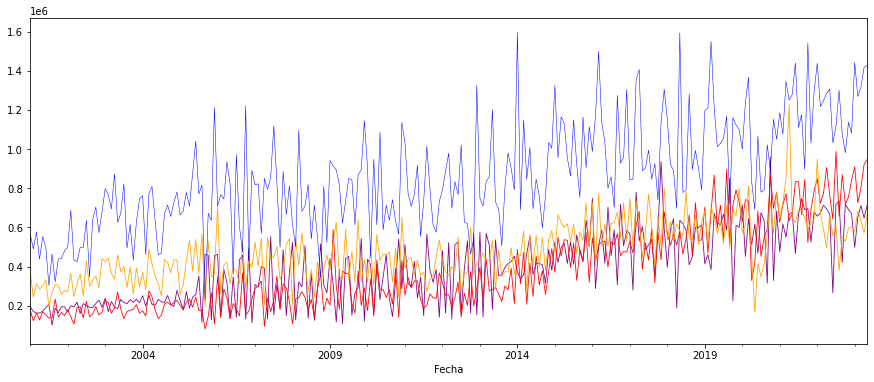

In [116]:
plt.figure(figsize=(15,6))
df_imp['Gas licuado de petróleo'].plot(color='purple', linewidth=0.8)
df_imp['Gasolina regular'].plot(color='red', linewidth=0.8)
df_imp['Gasolina superior'].plot(color='orange', linewidth=0.8)
df_imp['Diesel'].plot(color='blue', linewidth=0.5)
plt.show()

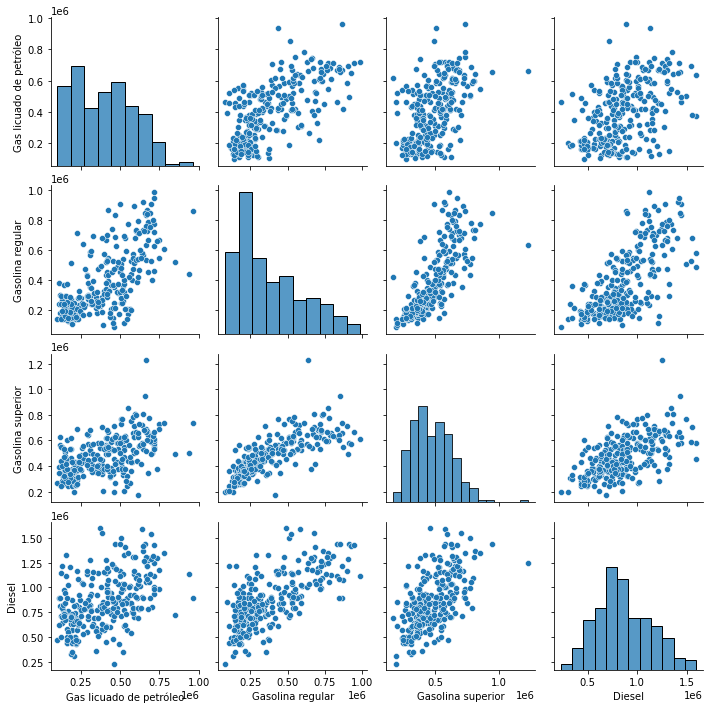

In [104]:
sns.pairplot(df_imp)
plt.show()

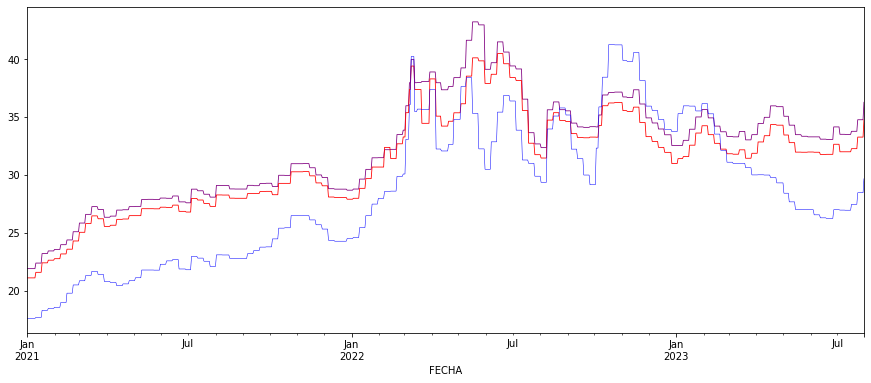

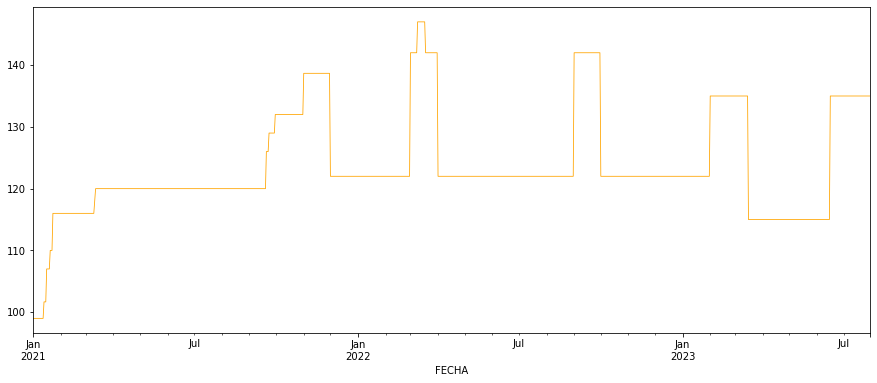

In [120]:
plt.figure(figsize=(15,6))
df_precios['Superior'].plot(color='purple', linewidth=0.8)
df_precios['Regular'].plot(color='red', linewidth=0.8)
df_precios['Diesel'].plot(color='blue', linewidth=0.5)
plt.show()

plt.figure(figsize=(15,6))
df_precios['Glp Cilindro 25Lbs.'].plot(color='orange', linewidth=0.8)
plt.show()

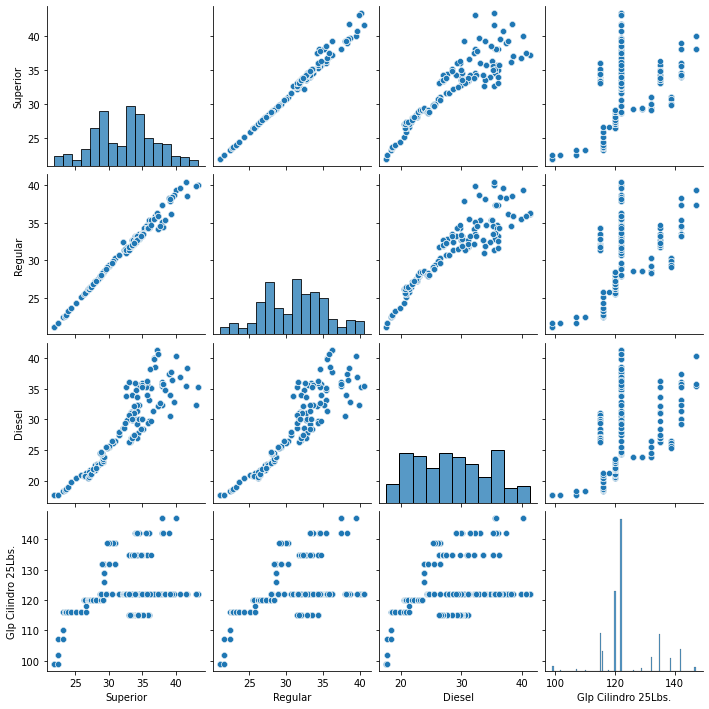

In [105]:
sns.pairplot(df_precios)
plt.show()

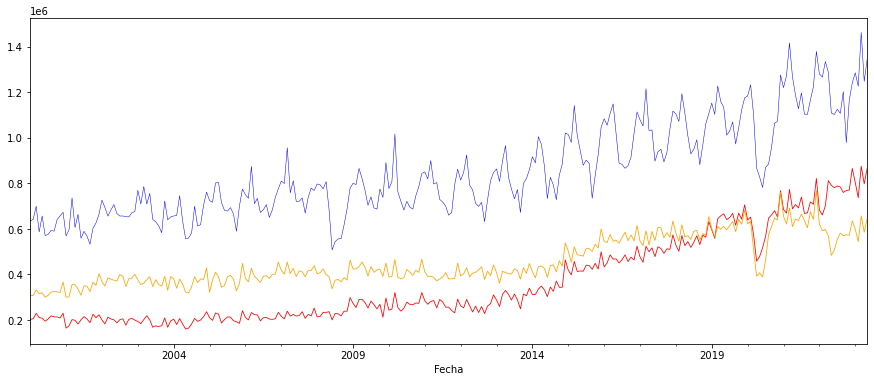

In [121]:
plt.figure(figsize=(15,6))
df_consumo['Gasolina regular'].plot(color='red', linewidth=0.8)
df_consumo['Gasolina superior'].plot(color='orange', linewidth=0.8)
df_consumo['Diesel'].plot(color='blue', linewidth=0.5)
plt.show()

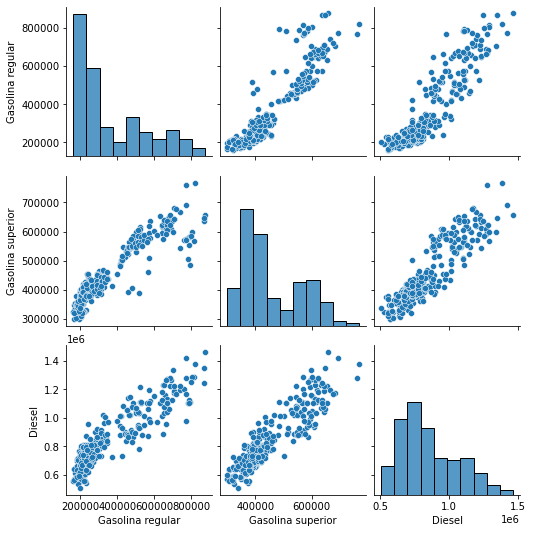

In [106]:
sns.pairplot(df_consumo)
plt.show()

## Descripción de las series de tiempo
Se importaron tres archivos:
1. De "IMPORTACION-VOLUMEN-2023-05" se importaron los volumenes de importación de combustibles de las columnas Diesel Bajo en Azufre, Gas Licuado de Petróleo, Gasolina Regular, Gsolina Superior y Diesel alto en Azufre calculado de forma mensual de Enero 2020 a Mayo 2023 dando 269 observaciones.
2. De  "Precios-Promedio-Nacionales-Diarios-2023" se importaron los precios promedio nacionales de forma diaria de las columnas de Super, Regular, Diesel y Gas Licuado Propano de 25 lbs un total de 942 observaciones.
3. De "CONSUMO-2023-05" se importaron los volúmenes de consumo mensuales de Diesel bajo zufre, Gasolina regulars, Gasolinea superior y Diesel alto azufre un total de 281 observaciones.